# Unsupervised Learning and Dimensionality Reduction

Things to do:
 - Rerun the Neural Network on the Adult Data using all samples and a scaler
 - Run k-means and EM algorithms on the scaled Adult Data. Describe what you see
 - Run PCA, ICA, and Randomized Projects on the scaled adult data. Describe what you see.
 - Rerun k-means and EM on the data after it has been run through each dimensionality reduction algorithm
 - Rerun Neural Network on dimensionality reduced Adult Data
 - Rerun Neural Network on clustered data (use clusters as features)

# Load in Adult Data and Preprocess

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import timeit
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.decomposition import PCA, FastICA
from sklearn.manifold import TSNE

In [2]:
train = pd.read_csv('adult_train.csv')
test = pd.read_csv('adult_test.csv')
test["income"] = test.income.apply(lambda x: x[:-1])
adult_data = pd.concat([train, test])
adult_data = adult_data.sample(n=1000)

In [3]:
categorical_columns = ["workclass", "education", "marital_status", "occupation",
                       "relationship", "race", "sex", "native_country", "income"]

adult_data = pd.get_dummies(adult_data, columns=categorical_columns)

In [4]:
y = adult_data["income_ >50K"]
X = adult_data.drop(["income_ >50K", "income_ <=50K"], axis=1)
X_columns = X.columns

In [5]:
y_train, y_test = train_test_split(y, test_size=0.1, stratify=y, random_state=42)
X_train, X_test = train_test_split(X, test_size=0.1, stratify=y, random_state=42)

In [6]:
rf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("random_forest", RandomForestClassifier(random_state=1))
])

rf = rf_pipeline.fit(X_train, y_train)
feature_importances = rf.named_steps["random_forest"].feature_importances_
features_df = pd.DataFrame({"feature" : X_train.columns, "importance" : feature_importances})
features_df = features_df.sort_values(by = "importance",
                                      ascending=False).reset_index(drop=True)

features_df.to_csv("feature_importances.csv")
columns_to_keep = list(features_df.iloc[:50, :].feature)

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.loc[:, columns_to_keep])
X_test = scaler.transform(X_test.loc[:, columns_to_keep])

# Run on a Neural Net

In [8]:
clf = MLPClassifier(max_iter=1000)

parameters = {
    'hidden_layer_sizes' : [tuple([x] * n) for x in range(10,100,10) for n in range(1,5)]
}

grid_search = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

gs_results = pd.DataFrame(grid_search.cv_results_)
gs_results.to_csv("nn_baseline.csv")

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

In [9]:
clf = MLPClassifier(max_iter=1000)

parameters = {
    'hidden_layer_sizes' : [tuple([x]) for x in range(1, 20)]
}

grid_search = GridSearchCV(clf, parameters, cv=10, n_jobs=-1)
grid_search.fit(X_train, y_train)

gs_results = pd.DataFrame(grid_search.cv_results_)
gs_results.to_csv("nn_baseline_2.csv")

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py

I performed a grid search on the standardized data, first testing one to five hidden layers of 10 to 100 nodes each. The search found that a single layer of 10 was the optimum, but only by a small amount. The second grid search tested a single hidden layer with one to twenty nodes. Above 3 nodes, all cross validation scores were within a fraction of a percent of each other. All neural nets in this experiment moving forward used a single hidden layer of 5 nodes.

In [10]:
clf = MLPClassifier(hidden_layer_sizes=(5))

base_cv = cross_val_score(estimator=clf, X=X_train, y=y_train, cv=10).mean()
base_cv

/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/ana

0.8288888888888888

# Analysis Through K-Means

In [11]:
cluster_error = pd.DataFrame(columns=["k", "time", "avg_inertia",
                                      "homogeneity", "completeness",
                                      "v_measure", "adj_rand",
                                      "adj_mutual_info", "silhouette"])

kmeans = KMeans()

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]

for k in k_range:
    print(f"training {k}-means!")
    t0 = timeit.default_timer()
    kmeans = kmeans.set_params(n_clusters=k).fit(X_train)
    labels = kmeans.labels_
    scores = {"k": k,
              "time" : timeit.default_timer() - t0,
              "avg_inertia": kmeans.inertia_/len(X_train),
              "homogeneity": metrics.homogeneity_score(y_train, labels),
              "completeness" : metrics.completeness_score(y_train, labels),
              "v_measure" : metrics.v_measure_score(y_train, labels),
              "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
              "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
              "silhouette": metrics.silhouette_score(X_train, labels,
                                                    metric='euclidean',
                                                    sample_size=300)
             }
    cluster_error = cluster_error.append(scores, ignore_index=True)

cluster_error

training 2-means!
training 5-means!
training 10-means!
training 15-means!
training 20-means!
training 25-means!
training 30-means!
training 40-means!
training 50-means!
training 100-means!


,k,time,avg_inertia,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,silhouette
0,2.0,0.082647,46.204196,0.203803,0.161076,0.179938,0.232027,0.160378,0.080694
1,5.0,0.095789,41.779433,0.205940,0.074055,0.108937,0.051238,0.072645,0.085131
2,10.0,0.154819,37.639363,0.226037,0.063927,0.099666,0.064501,0.061343,0.109444
3,15.0,0.175597,33.358503,0.269354,0.056238,0.093048,0.028119,0.053269,0.108102
4,20.0,0.226428,29.834372,0.295219,0.058694,0.097920,0.029663,0.054723,0.099051
5,25.0,0.249411,26.833493,0.291509,0.050383,0.085917,0.012981,0.046040,0.124582
6,30.0,0.314657,24.574034,0.265288,0.042866,0.073806,0.008788,0.037902,0.137653
7,40.0,0.353920,21.911416,0.285417,0.042232,0.073577,0.005562,0.036028,0.104488
8,50.0,0.576526,20.224808,0.331456,0.046484,0.081534,0.006643,0.038990,0.128570
9,100.0,0.820173,15.335622,0.418074,0.050082,0.089448,0.003387,0.036407,0.132674


In [12]:
kmeans_labels = kmeans.set_params(n_clusters=2).fit(X_train).labels_

# Analysis Through EM

In [13]:
em_error = pd.DataFrame(columns=["k", "time", "lower_bound",
                                 "homogeneity", "completeness",
                                 "v_measure", "adj_rand",
                                  "adj_mutual_info", "BIC", "silhouette"])

em = GaussianMixture()

k_range = [2, 5, 10, 15, 20, 25, 30, 40, 50, 100]

for k in k_range:
    print(f"training {k}-means!")
    t0 = timeit.default_timer()
    em = em.set_params(n_components=k).fit(X_train)
    labels = em.predict(X_train)
    scores = {"k": k,
              "time" : timeit.default_timer() - t0,
              "lower_bound": em.lower_bound_,
              "homogeneity": metrics.homogeneity_score(y_train, labels),
              "completeness" : metrics.completeness_score(y_train, labels),
              "v_measure" : metrics.v_measure_score(y_train, labels),
              "adj_rand" : metrics.adjusted_rand_score(y_train, labels),
              "adj_mutual_info" : metrics.adjusted_mutual_info_score(y_train, labels),
              "BIC" : em.bic(X_train),
              "silhouette": metrics.silhouette_score(X_train, labels,
                                                    metric='euclidean',
                                                    sample_size=300)
             }
    em_error = em_error.append(scores, ignore_index=True)
    
em_error

training 2-means!
training 5-means!
training 10-means!
training 15-means!
training 20-means!
training 25-means!
training 30-means!
training 40-means!
training 50-means!
training 100-means!


,k,time,lower_bound,homogeneity,completeness,v_measure,adj_rand,adj_mutual_info,BIC,silhouette
0,2.0,0.417451,-38.720726,0.000234,0.001079,0.000384,-0.005873,-0.000864,87730.456111,0.173333
1,5.0,0.269139,45.284708,0.090281,0.033734,0.049116,-0.011435,0.032193,-36419.400293,0.026326
2,10.0,0.232191,65.239994,0.295126,0.073366,0.117519,0.028639,0.071153,-27239.037615,0.073511
3,15.0,0.867749,102.572853,0.221695,0.046680,0.077122,0.015593,0.043643,-49340.419391,0.083870
4,20.0,0.556112,118.132404,0.271142,0.051244,0.086198,0.015308,0.047513,-32253.139923,0.089254
5,25.0,0.360585,148.680973,0.235669,0.039480,0.067631,0.010268,0.035281,-42133.167845,0.097973
6,30.0,0.653512,156.383040,0.308563,0.050367,0.086598,0.011824,0.045394,-10897.010830,0.101212
7,40.0,1.461656,177.478131,0.275560,0.040964,0.071324,0.006205,0.034716,41331.579588,0.111434
8,50.0,0.589034,189.042231,0.321929,0.045123,0.079151,0.006058,0.037594,110715.954001,0.122916
9,100.0,1.518184,233.278201,0.422276,0.050256,0.089823,0.003374,0.036643,482089.980521,0.119179


In [14]:
em_labels = em.set_params(n_components=2).fit(X_train).predict(X_train)

# t-SNE Graph

In [15]:
perplexities = [2, 5, 10, 20, 30, 50, 100, 200]

X_tsne = pd.DataFrame(columns=["X1", "X2", "perplexity", "training_time"])
for perplexity in perplexities:
    tsne = TSNE(n_components=2, random_state=341, perplexity=perplexity)
    t0 = timeit.default_timer()
    temp = pd.DataFrame(tsne.fit_transform(X_train), columns=["X1", "X2"])
    temp = temp.assign(y = np.array(y_train),
                       kmeans_cluster = kmeans_labels,
                       em_cluster = em_labels,
                       perplexity=perplexity,
                       training_time = timeit.default_timer() - t0)
    X_tsne = pd.concat([X_tsne, temp], sort=True)

X_tsne

,X1,X2,em_cluster,kmeans_cluster,perplexity,training_time,y
0,-0.566725,75.076225,1.0,0.0,2,20.745365,0.0
1,-46.807156,12.431044,0.0,0.0,2,20.745365,0.0
2,-41.285557,59.947235,0.0,1.0,2,20.745365,1.0
3,13.903019,14.801255,0.0,0.0,2,20.745365,0.0
4,-16.783539,55.139091,0.0,0.0,2,20.745365,0.0
5,-55.612129,-25.109709,0.0,1.0,2,20.745365,1.0
6,4.080710,28.512999,0.0,0.0,2,20.745365,0.0
7,-24.567680,47.810272,0.0,0.0,2,20.745365,0.0
8,28.729858,10.403788,0.0,0.0,2,20.745365,0.0
9,-8.261693,-59.238667,1.0,1.0,2,20.745365,0.0


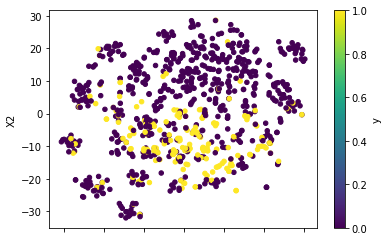

In [16]:
X_tsne[X_tsne.perplexity == 50].plot.scatter(x='X1', y='X2', c="y", colormap='viridis')

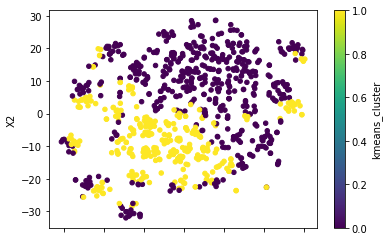

In [17]:
X_tsne[X_tsne.perplexity == 50].plot.scatter(x='X1', y='X2', c="kmeans_cluster", colormap='viridis')

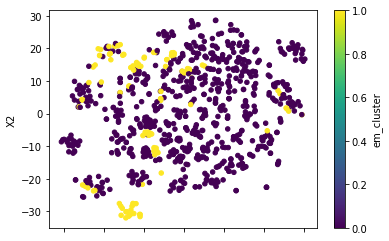

In [18]:
X_tsne[X_tsne.perplexity == 50].plot.scatter(x='X1', y='X2', c="em_cluster", colormap='viridis')

# Principal Component Analysis

In [30]:
pca = PCA(random_state=2).fit(X_train)
pca_var = pd.DataFrame(pca.explained_variance_)
pca_var.to_csv("pca_explained_variance.csv")
pca_var

,0
0,4.398866e+00
1,2.933770e+00
2,2.286387e+00
3,2.140149e+00
4,1.785705e+00
5,1.741050e+00
6,1.539385e+00
7,1.503291e+00
8,1.362622e+00
9,1.329342e+00


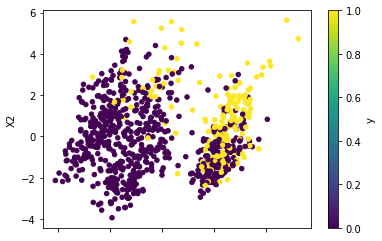

In [20]:
pca = PCA(random_state=2, n_components=2).fit_transform(X_train)
pca = pd.DataFrame(pca, columns=["X1","X2"]).assign(y = np.array(y_train))
pca.plot.scatter(x='X1', y='X2', c='y', colormap='viridis')

# Independent Component Analysis

In [27]:
n_components = [2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]

kurtosis = {'n' : [], 'kurtosis': []}
for n in n_components:
    ica = FastICA(random_state=34, n_components=n).fit_transform(X_train)
    kurtosis['n'].append(n)
    kurtosis['kurtosis'].append(pd.DataFrame(ica).kurt().abs().mean())
    
kurtosis = pd.DataFrame(kurtosis)
kurtosis.to_csv("ica_kurtosis.csv")
kurtosis

/anaconda3/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:118: UserWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn('FastICA did not converge. Consider increasing '


,n,kurtosis
0,2,0.736295
1,3,0.980892
2,4,1.462182
3,5,1.355692
4,10,4.227450
5,15,5.562638
6,20,12.185267
7,25,13.874939
8,30,20.472608
9,40,29.895383


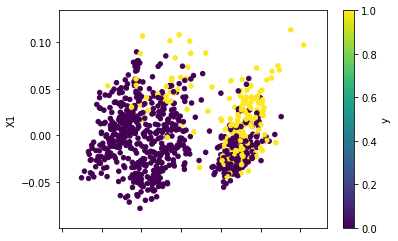

In [22]:
ica = FastICA(random_state=34, n_components=2).fit_transform(X_train)
ica = pd.DataFrame(ica, columns=["X1","X2"]).assign(y = np.array(y_train))
ica.plot.scatter(x='X2', y='X1', c='y', colormap='viridis')

In [28]:
ica = FastICA(random_state=34, n_components=40).fit_transform(X_train)

In [29]:
perplexities = [2, 5, 10, 20, 30, 50, 100, 200]

X_ica_tsne = pd.DataFrame(columns=["X1", "X2", "perplexity", "training_time"])
for perplexity in perplexities:
    tsne = TSNE(n_components=2, random_state=341, perplexity=perplexity)
    t0 = timeit.default_timer()
    temp = pd.DataFrame(tsne.fit_transform(ica), columns=["X1", "X2"])
    temp = temp.assign(y = np.array(y_train),
                       kmeans_cluster = kmeans_labels,
                       em_cluster = em_labels,
                       perplexity=perplexity,
                       training_time = timeit.default_timer() - t0)
    X_ica_tsne = pd.concat([X_tsne, temp], sort=True)

X_ica_tsne.head()

,X1,X2,em_cluster,kmeans_cluster,perplexity,training_time,y
0,-0.566725,75.076225,1.0,0.0,2,20.745365,0.0
1,-46.807156,12.431044,0.0,0.0,2,20.745365,0.0
2,-41.285557,59.947235,0.0,1.0,2,20.745365,1.0
3,13.903019,14.801255,0.0,0.0,2,20.745365,0.0
4,-16.783539,55.139091,0.0,0.0,2,20.745365,0.0
5,-55.612129,-25.109709,0.0,1.0,2,20.745365,1.0
6,4.080710,28.512999,0.0,0.0,2,20.745365,0.0
7,-24.567680,47.810272,0.0,0.0,2,20.745365,0.0
8,28.729858,10.403788,0.0,0.0,2,20.745365,0.0
9,-8.261693,-59.238667,1.0,1.0,2,20.745365,0.0


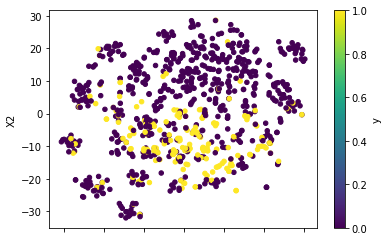

In [25]:
X_ica_tsne[X_ica_tsne.perplexity == 50].plot.scatter(x='X1', y='X2', c="y", colormap='viridis')

# Random Projection

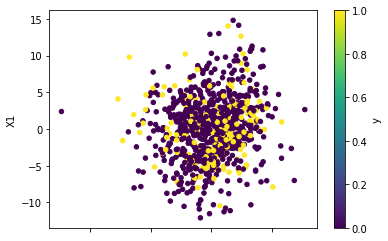

In [26]:
rp = GaussianRandomProjection(n_components=2, random_state=13)
X_rp = pd.DataFrame(rp.fit_transform(X_train), columns=["X1", "X2"])
X_rp = X_rp.assign(y = np.array(y_train))
X_rp.plot.scatter(x='X2', y='X1', c='y', colormap='viridis')